In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

# Input space transformation (dimensionality reduction)
from sklearn.decomposition import PCA
from sklearn import random_projection
from sklearn import cluster
from sklearn.random_projection import johnson_lindenstrauss_min_dim

import utils

from clustering_adv_sample_detection import ClusterAdversarialClassifier as Classifier

## Testing Cluster Adversarial Classifier

### Load Data

In [2]:
# MNIST
X_train, y_train, X_test, y_test = utils.load_mnist()

# Perfomance on MNIST with PCA transform, FC NN, and eps=3e-2: 
# Wall time: 1min 33s
# Cluster Classifier Accuracy on clean data: 97.930
# Cluster Classifier Accuracy on adversarial data: 92.460
# Percentage of input data flagged as suspicious by detector: 45.670

# Fashion MNIST
#X_train, y_train, X_test, y_test = utils.load_fashion_mnist()

# Perfomance on Fashion MNIST with PCA transform, FC NN, and eps=3e-2: 
# Wall time: 2min
# Cluster Classifier Accuracy on clean data: 87.760
# Cluster Classifier Accuracy on adversarial data: 79.280
# Percentage of input data flagged as suspicious by detector: 46.340

# CIFAR-10
#X_train, y_train, X_test, y_test = utils.load_cifar10()

# Perfomance on CIFAR-10 with PCA transform, FC NN, and eps=3e-2:  
# Wall time: 8min 28s
# Cluster Classifier Accuracy on clean data: 51.990
# Cluster Classifier Accuracy on adversarial data: 43.500
# Percentage of input data flagged as suspicious by detector: 55.520

### Train Base Neural Network

In [3]:
from model import My_VGG as Model

In [4]:
model = Model(in_channels=1, in_size=28, num_classes=10)

c:\users\jason\appdata\local\programs\python\python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 0 - Training loss: 0.2528028489608786
Epoch 1 - Training loss: 0.10984951216548436
Epoch 2 - Training loss: 0.10897432890436166
Epoch 3 - Training loss: 0.0888661191825345
Epoch 4 - Training loss: 0.053334344225653765

Training Time (in minutes) = 2.5477556308110554
Predicted Digit = 5
Number Of Images Tested = 10000

Model Accuracy = 0.9912


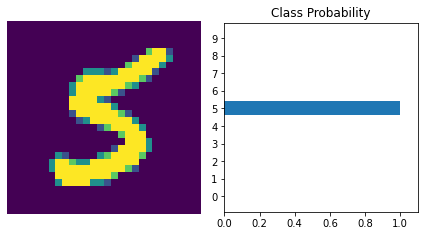

In [5]:
# Now let's start training the network
# input_size = X_train.shape[1]
# hidden_sizes = [128, 64]
# output_size = 10

# model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
#                       nn.ReLU(),
#                       nn.Linear(hidden_sizes[0], hidden_sizes[1]),
#                       nn.ReLU(),
#                       nn.Linear(hidden_sizes[1], output_size),
#                       nn.LogSoftmax(dim=1))

model = utils.train_model(model, X_train, X_test, y_train, y_test, epochs=5)

### Testing base model on adversarial data

In [6]:
eps = 1e-1

test_dataloader = utils.create_dataloader(X_test, y_test)
adv_test_data = utils.add_adversarial_noise(model, test_dataloader, eps=eps)

In [7]:
# Model accuracy on adversarial data
utils.eval_model(model, adv_test_data, y_test)

Number Of Samples Tested = 10000

Model Accuracy = 0.6664


### Input Space (Dimensionality Reduction) Transforms - optional

In [8]:
# SKLearn method for determining a "minimum" number of components to reduce the dataset to
n_comp = johnson_lindenstrauss_min_dim(X_train.shape[0], eps=.99)

# Control (no transform): Wall time: 2min 53s, clean: 0.9733, adv: 0.8829
#transformer = None

# GaussianRandomProjection(n_components=374): Wall time: 1min 47s, clean: 0.9737, adv: 0.8892
# 2nd run: Wall time: 1min 52s, clean: 0.9727, adv: 0.911
#transformer = random_projection.GaussianRandomProjection(n_components=n_comp)

# SparseRandomProjection(n_components=374): Wall time: 1min 46s, clean: 0.9744, adv: 0.9247
# 2nd run: Wall time: 1min 47s, clean: 0.9706, adv: 0.8998
#transformer = random_projection.SparseRandomProjection(n_components=n_comp)

# PCA(n_components=374): Wall time: 1min 53s, clean: 0.9783, adv: 0.9137
# 2nd run: Wall time: 1min 32s, clean: 0.9757, adv: 0.9028
transformer = PCA(n_components=n_comp)

# FeatureAgglomeration(n_clusters=10):  Wall time: 46.2 s, clean: 0.8512, adv: 0.782
#transformer = cluster.FeatureAgglomeration(n_clusters=10)

### Fitting and scoring the classifier on clean data

In [9]:
classifier = Classifier(model, transformer)

%time classifier.fit(X_train, y_train)
print("Cluster Classifier Accuracy on clean data: %.3f" % (classifier.score(X_test, y_test) * 100.0))

Wall time: 1min 46s
Cluster Classifier Accuracy on clean data: 98.280


### Scoring the classifier on clean and adversarial data

In [10]:
test_data = np.concatenate((X_test, adv_test_data), axis=0)
test_labels = np.concatenate((y_test, y_test), axis=0)

In [11]:
print("Cluster Classifier Accuracy on clean and adversarial data: %.3f" % (classifier.score(adv_test_data, y_test) * 100.0))
print("Percentage of input data flagged as suspicious by detector: %.3f" % (classifier.proportion_flagged * 100))

Cluster Classifier Accuracy on clean and adversarial data: 89.240
Percentage of input data flagged as suspicious by detector: 44.670


## Baseline Method - Adversarial Training

### Generate adversarial data

In [12]:
train_dataloader = utils.create_dataloader(X_train, y_train)
adv_train_data = utils.add_adversarial_noise(model, train_dataloader, eps=eps)

In [13]:
baseline_train_data = np.concatenate((X_train, adv_train_data), axis=0)
baseline_train_labels = np.concatenate((y_train, y_train), axis=0)

### Train model with mix of clean and adversarial data

In [14]:
baseline_model = Model(in_channels=1, num_classes=10)

Epoch 0 - Training loss: 0.18734501579213345
Epoch 1 - Training loss: 0.1045422577765252
Epoch 2 - Training loss: 0.04606292678967327
Epoch 3 - Training loss: 0.03704353494210991
Epoch 4 - Training loss: 0.036293665838820564

Training Time (in minutes) = 4.833556481202444
Predicted Digit = 3
Number Of Images Tested = 20000

Model Accuracy = 0.992


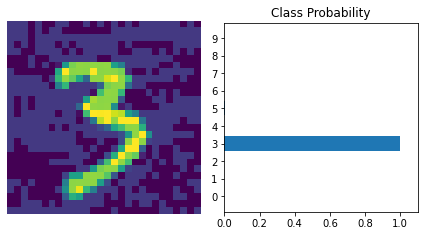

In [15]:
baseline_model = utils.train_model(baseline_model, baseline_train_data, test_data, baseline_train_labels, test_labels, epochs=5)

In [16]:
print("Baseline classifier on clean test data: ")
utils.eval_model(baseline_model, X_test, y_test)
print("Baseline classifier on adversarial test data: ")
utils.eval_model(baseline_model, adv_test_data, y_test)

Baseline classifier on clean test data: 
Number Of Samples Tested = 10000

Model Accuracy = 0.9917
Baseline classifier on adversarial test data: 
Number Of Samples Tested = 10000

Model Accuracy = 0.9923
